In [ ]:
 import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as T
import torch.optim as optim

In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,**kwargs):
        super(BasicConv2d,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,bias=False,**kwargs)
        self.bn = nn.BatchNorm2d(out_channels,eps=0.001)

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x,inplace=True)

In [ ]:
class InceptionA(nn.Module):
    def __init__(self, in_channels, pool_features):
        super(InceptionA,self).__init__()
        self.branch1x1 = BasicConv2d(in_channels,64,kernel_size = 1)

        self.branch5x5_1 = BasicConv2d(in_channels,48,kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48,64,kernel_size=5,padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels,64,kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64,96,kernel_size=3,padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96,96,kernel_size=3,padding=1)

        self.branch_pool = BasicConv2d(in_channels,pool_features,kernel_size=1)
    def forward(self,x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x,kernel_size=3,stride=1,padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1,branch5x5,branch3x3dbl,branch_pool]
        return torch.cat(outputs,1)            

In [ ]:
class InceptionB(nn.Module):
    def __init__(self, in_channels):
        super(InceptionB,self).__init__()
        self.branch3x3 = BasicConv2d(in_channels,384,kernel_size = 3,stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels,64,kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64,96,kernel_size=3,padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96,96,kernel_size=3,stride=2)

    def forward(self,x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x,kernel_size=3,stride=2)

        outputs = [branch3x3,branch3x3dbl,branch_pool]
        return torch.cat(outputs,1)      

In [ ]:
class InceptionC(nn.Module):
    def __init__(self,in_channels,channels_7x7):
        super(InceptionC,self).__init__()
        self.branch1x1 = BasicConv2d(in_channels,192,kernel_size=1)

        c7=channels_7x7
        self.branch7x7_1=BasicConv2d(in_channels,c7,kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7,c7,kernel_size = (1,7),padding=(0,3))
        self.branch7x7_3 = BasicConv2d(c7,192,kernel_size = (7,1),padding=(3,0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels,192,kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


In [ ]:
class InceptionD(nn.Module):
    def __init__(self, in_channels):
        super(InceptionD, self).__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return torch.cat(outputs, 1)

In [ ]:
class InceptionE(nn.Module):
    def __init__(self, in_channels):
        super(InceptionE, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [ ]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = x.view(x.size(0), -1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x

In [ ]:
class Inception3(nn.Module):
    # CIFAR10: aux_logits True->False
    def __init__(self, num_classes=10, aux_logits=False, transform_input=False):
        super(Inception3, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input

        # CIFAR10: stride 2->1, padding 0 -> 1
        self.Conv2d_1a_3x3 = BasicConv2d(3, 192, kernel_size=3, stride=1, padding=1)
        #         self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        #         self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        #         self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        #         self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)
        if aux_logits:
            self.AuxLogits = InceptionAux(768, num_classes)
        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)
        self.fc = nn.Linear(2048, num_classes)

    #         for m in self.modules():
    #             if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    #                 import scipy.stats as stats
    #                 stddev = m.stddev if hasattr(m, 'stddev') else 0.1
    #                 X = stats.truncnorm(-2, 2, scale=stddev)
    #                 values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
    #                 values = values.view(m.weight.size())
    #                 with torch.no_grad():
    #                     m.weight.copy_(values)
    #             elif isinstance(m, nn.BatchNorm2d):
    #                 nn.init.constant_(m.weight, 1)
    #                 nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)

        # CIFAR10
        # N x 32 x 149 x 149
        #         x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        #         x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        #         x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 64 x 73 x 73
        #         x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        #         x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        #         x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        if self.training and self.aux_logits:
            aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 2048 x 1 x 1
        x = F.dropout(x, training=self.training)
        # N x 2048 x 1 x 1
        x = x.view(x.size(0), -1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:
            return _InceptionOuputs(x, aux)
        return x


In [ ]:
transforms = T.Compose([
                        T.RandomCrop((32,32),padding=(4,4)),
                        T.RandomHorizontalFlip(p=0.5),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                        
])

trainset = dsets.CIFAR100(root = '../datasets',train=True,transform=transforms,download=True)
testset = dsets.CIFAR100(root='../datasets',train=False,transform=T.Compose([         #T.RandomCrop((32,32),padding=(4,4)),
                                                                                                                    # T.RandomHorizontalFlip(p=0.5),
                                                                                                                    T.ToTensor(),
                                                                                                                    T.Normalize(mean=[0.485,0.456,0.406],
                                                                                                                                std = [0.229,0.224,0.225])
]),download=True)
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

NameError: ignored

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainset,batch_size = 128,shuffle = True)
testLoader = torch.utils.data.DataLoader(testset,batch_size =128,shuffle=False,drop_last=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Inception3()
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(),lr=0.05,momentum=0.9,weight_decay=5e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)

In [ ]:

def check_accuracy(network,testLoader):
    class_correct = list(0. for i in range(100))
    class_total = list(0. for i in range(100))
    with torch.no_grad():
        for data in testLoader:
            images,labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = network(images)
            #
            _,predicted = torch.max(outputs,1)
            c = (predicted == labels).squeeze()
            for i in range(128):
                label = labels[i]
                class_correct[label] +=c[i].item()
                class_total[label] +=1
    accuracy_sum = 0
    for i in range(10):
        temp = 100* class_correct[i] / class_total[i]
        accuracy_sum += temp
    return accuracy_sum / 10

In [ ]:

def show_accuracy(network,testLoader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testLoader:
            images,labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = network(images)
            #
            _,predicted = torch.max(outputs,1)
            c = (predicted == labels).squeeze()
            for i in range(128):
                label = labels[i]
                class_correct[label] +=c[i].item()
                class_total[label] +=1
    accuracy_sum = 0
    for i in range(10):
        temp = 100* class_correct[i] / class_total[i]
        print('Accuracy of %5s : %2d %%'%(classes[i],temp))
        accuracy_sum += temp
    print('Accuracy average: ',accuracy_sum / 10)

In [ ]:
epochs_accuracy_list = []
epochs_accuracy = 0
lr = 0.05
for epoch in range(200):
    running_loss = 0.0
    avg_loss=0.0
    for i,data in enumerate(trainLoader,0):
        print("{}-th trainLoader batch!".format(i))
        #get the inputs
        inputs,labels = data
        inputs,labels = inputs.to(device),labels.to(device)
        #zero the parameter gradients
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # # print statistics
        # running_loss += loss.item()
        # avg_loss += loss.item()
        # if i%50 ==49:
        #     print('[%d,%5d] loss: %.3f'%(epoch+1,i+1,running_loss/50))
        #     running_loss=0.0

    # if abs(pre_avg_loss-avg_loss)<=0.01 and epoch!=0:
    #     print("learning rate 50% reduced.")
    #     scheduler.step()
    acc = check_accuracy(net,testLoader)
    print("epoch: {} | Accuracy: {}".format(epoch,acc))
    epochs_accuracy_list.append(acc)
    
    if epoch % 5 == 0:
        show_accuracy(net,testLoader)

print('Finished Training')



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
201-th trainLoader batch!
202-th trainLoader batch!
203-th trainLoader batch!
204-th trainLoader batch!
205-th trainLoader batch!
206-th trainLoader batch!
207-th trainLoader batch!
208-th trainLoader batch!
209-th trainLoader batch!
210-th trainLoader batch!
211-th trainLoader batch!
212-th trainLoader batch!
213-th trainLoader batch!
214-th trainLoader batch!
215-th trainLoader batch!
216-th trainLoader batch!
217-th trainLoader batch!
218-th trainLoader batch!
219-th trainLoader batch!
220-th trainLoader batch!
221-th trainLoader batch!
222-th trainLoader batch!
223-th trainLoader batch!
224-th trainLoader batch!
225-th trainLoader batch!
226-th trainLoader batch!
227-th trainLoader batch!
228-th trainLoader batch!
229-th trainLoader batch!
230-th trainLoader batch!
231-th trainLoader batch!
232-th trainLoader batch!
233-th trainLoader batch!
234-th trainLoader batch!
235-th trainLoader batch!
236-th trainLoader batch!
237-th trainLoader batch!
23

KeyboardInterrupt: ignored

In [ ]:
torch.save(net,'/content/drive/MyDrive/lab/InceptionV2/inception.pth')

In [ ]:
print(epochs_accuracy_list)

[38.641123281419155, 48.85539480296734, 57.380987917664825, 62.55346289590436, 65.61103447113382, 71.3396372752191, 71.99143101387065, 75.12610334929555, 75.20619374131388, 80.45420454957261, 79.38332244321234, 79.75278011550844, 81.8587676177151, 83.74984813584466, 82.630170946399, 82.27069235101439, 84.1933180245288, 81.39721319484723, 84.89436131496147, 83.85118294156413]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data = epochs_accuracy_list

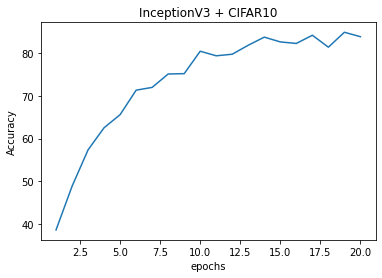

In [ ]:
plt.title("InceptionV3 + CIFAR10")
plt.plot(list(range(1,len(epochs_accuracy_list)+1)),data)
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()